Makes .spx files as inputs to NEMESIS. Requires I/F as a function of wavelength as input, as well as geometric information. Make I/F files using IF_maker.ipynb, get geometric info from Spectra_extractor.ipynb. 

Units of radiance for NEMESIS: nW/ster/cm2/micron

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import interpolate
from uncertainties import ufloat
from uncertainties.umath import *

### Convert I/F data to radiance

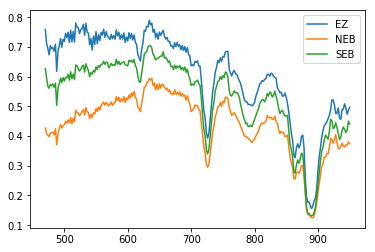

In [3]:
# load IF file, wavelengths
# IF file loaded here has the format wl, IF_EZ, IF_EZ_error, IF_NEB, IF_NEB_error, etc

directory = '/Users/dahlek/Desktop/nemesis_inputs_march2019/'
IF_file = np.loadtxt('/Users/dahlek/Desktop/nemesis_inputs_march2019/IF_ave_march2017_cube5')

wl = IF_file[:,0]
wl_micron = wl*0.001


plt.plot(IF_file[:,0],IF_file[:,1]) # EZ
plt.plot(IF_file[:,0],IF_file[:,3]) # NEB
plt.plot(IF_file[:,0],IF_file[:,5]) # SEB
plt.legend(['EZ','NEB','SEB'])
plt.show()

In [ ]:
# load in solar spectrum to multiply by I/F. Needs to be the same file defined in runname.sol in NEMESIS directory
F_S_standard = np.loadtxt('/Users/dahlek/Desktop/NAIC/std_spec/nemesis_thuillier_solar_spec')

#use corrected wavelengths, interpolate flux
F_S_func = interpolate.interp1d(F_S_standard[:,0],F_S_standard[:,1])

F_S_corrwl = []

for i in range(0,len(IF_file[:,0])):
    F_S_corrwl.append(F_S_func(IF_file[i,0])) 

In [ ]:
r = 5.45 #AU Sun distance to Jupiter in March 2017

rad_EZ_error = []
rad_NEB_error = []
rad_SEB_error = []

for j in range(0,(len(wl))):
    F_Solar = ufloat(F_S_corrwl[j],F_S_corrwl[j]*0.01) # assuming 1% error
    
    # Load IF values and errors
    IF_EZ_error = ufloat(IF_file[j,1],IF_file[j,2])
    IF_NEB_error = ufloat(IF_file[j,3],IF_file[j,4])
    IF_SEB_error = ufloat(IF_file[j,5],IF_file[j,6])
    
    # calculate radiance
    rad_EZ_error.append(IF_EZ_error*1e-7*(1/0.0001)*(F_Solar/(r**2)/math.pi))
    rad_NEB_error.append(IF_NEB_error*1e-7*(1/0.0001)*(F_Solar/(r**2)/math.pi))
    rad_SEB_error.append(IF_SEB_error*1e-7*(1/0.0001)*(F_Solar/(r**2)/math.pi))
    
# seperate error and value
EZ_rad = []
EZ_error = []
NEB_rad = []
NEB_error = []
SEB_rad = []
SEB_error = []

for i in range(0,(len(wl))):
    EZ_rad.append(float('{:10.8f}'.format(rad_EZ_error[i])[:10]))
    EZ_error.append( float('{:10.8f}'.format(rad_EZ_error[i])[13:]))
    NEB_rad.append(float('{:10.8f}'.format(rad_NEB_error[i])[:10]))
    NEB_error.append( float('{:10.8f}'.format(rad_NEB_error[i])[13:]))
    SEB_rad.append(float('{:10.8f}'.format(rad_SEB_error[i])[:10]))
    SEB_error.append( float('{:10.8f}'.format(rad_SEB_error[i])[13:]))

In [ ]:
# Diagnostic plot, with errorbars
plt.errorbar(wl_micron[:],EZ_rad,yerr=EZ_error)
plt.errorbar(wl_micron[:],SEB_rad,yerr=SEB_error)
plt.errorbar(wl_micron[:],NEB_rad,yerr=NEB_error)

plt.show()

### Make input for .spx file

In [ ]:
# !! Change these to which ever feature you're making a .spx file for
rad_ave = np.copy(EZ_rad)
error = np.copy(EZ_error)
geo = np.loadtxt('/Users/dahlek/Desktop/nemesis_inputs_march2019/EZ_averaged_geo5')

wl_micron = np.linspace(0.47,0.95,241)

In [ ]:
# Take AVERAGE of geometric information. This is appropriate for spectra straddling the meridian - Use binning routine if your spectra cover more different viewing geometries
latitude = round(np.mean(geo[:,2]),3)
longitude = round(np.mean(geo[:,3]),3)
zenith = round(np.mean(geo[:,5]),3) # zenith angle
szenith = round(np.mean(geo[:,6]),3) # solar zenith angle
azi = round(np.mean(geo[:,7]),3) # azmiuth angle

In [ ]:
# Checking values:
print 'lat, long, zenith angle, solar zenith angle, azimuth'
print latitude, longitude, zenith, szenith, azi

In [ ]:
# NEMESIS-specific header info - can find definitions for these things in the manual
FWHM = 0 
LATITUDE = latitude
LONGITUDE = longitude
NGEOM = 1 # just one average geometry
NCONV = len(wl) # change if fix interpolation range
NAV = 1

FLAT = latitude
FLON = longitude
SOL_ANG = szenith # average solar angle
EMISS_ANG = zenith
AZI_ANG = azi
WGEOM = 1.0

In [ ]:
# Print out the header and info.
# Copy and paste this into an spx file
print '     ',FWHM,'  ', LATITUDE,'  ', LONGITUDE,'  ', NGEOM
print '     ',NCONV
print '     ',NAV
print '     ',FLAT,'  ',FLON,'  ',SOL_ANG,'  ',EMISS_ANG,'  ',AZI_ANG,'  ',WGEOM
for i in range(0,len(wl_micron)):
    print '     ',round(wl_micron[:][i]+0.00000,6), round(rad_ave[i],6), round(error[i],7)

In [ ]:
# in case you'd like to save the radiance to a seperate file:
dummy = np.zeros((len(wl_micron),2))
dummy[:,0] = wl_micron
dummy[:,1] = rad_EZ
np.savetxt('/Users/dahlek/Desktop/nemesis_inputs_march2019/EZ_microns_radiance',dummy)

### Make binned .spx file (viewing geometry not averaged)

In [ ]:
wl_micron = np.linspace(0.47,0.95,241)

In [ ]:
# copy spectra - CHANGE THESE
rad_ave = np.copy(SEB_rad)
error = np.copy(SEB_error)
geo = np.loadtxt('/Users/dahlek/Desktop/nemesis_inputs_march2019/SEB_averaged_geo5')

# load corresponding .spx file from the nadir measurements
nadir_spx = '/Users/dahlek/Desktop/nemesis_inputs_march2019/seb_nemsolar_july_18_2019.spx'
with open(nadir_spx,'r') as f:
    all_data=[x.split() for x in f.readlines()]
    header = np.asfarray(all_data[0])
    nconv_nadir = np.asfarray(all_data[1])
    nav_nadir = np.asfarray(all_data[2])
    geom_line_nadir = np.asfarray(all_data[3])
    spec_nadir = np.asfarray(all_data[4:])
    for i in range(0,len(all_data)):
        print np.asfarray(all_data[i])

In [ ]:
# Check number of bins

number_of_bins = 10
number_of_nconv = len(wl_micron)/number_of_bins
remainder = len(wl_micron)%number_of_bins

print 'Will have',number_of_nconv,'points for each viewing geometry, with',remainder,'points left over at the end'

array_of_nconv = []
for i in range(0,number_of_bins):
    if i == number_of_bins-1:
        array_of_nconv.append(number_of_nconv+remainder)
    else:
        array_of_nconv.append(number_of_nconv)
        
print 'nconv:',array_of_nconv

In [ ]:
# Load geometric information from new spectrum
latitude = geo[:,2]
longitude = geo[:,3]
zenith = geo[:,5] # zenith angle
szenith = geo[:,6] # solar zenith angle
azi = geo[:,7] # azmiuth angle

In [ ]:
# pull spectra, geometry info for each bin
# print everything to check

# make header
lat_bin_array = [] # for header
long_bin_array = [] # for header
index1 = 0
index2 = 0
for j in range(0,len(array_of_nconv)):
    index2 += array_of_nconv[j]
    lat_bin_array.append(np.round(np.mean(latitude[index1:index2]),3)) # for header
    long_bin_array.append( np.round(np.mean(longitude[index1:index2]),3)) # for header
    index1 += array_of_nconv[j]

# new header
print '0', np.round(np.mean(lat_bin_array),3),np.round(np.mean(long_bin_array),3),number_of_bins+1 # assuming just the 1 nadir spectrum plus however many binned viewing geometries


# original nadir spectrum
print int(nconv_nadir)
print int(nav_nadir)
print str(geom_line_nadir)[2:-1]
for q in range(0,len(spec_nadir)):
    print str(spec_nadir[q])[1:-1]

# binned viewing geomtries from limb
index1 = 0
index2 = 0
for j in range(0,len(array_of_nconv)):
    index2 += array_of_nconv[j]
    #print index1,index2
    #print wl_micron[index1:index2]
    #print rad_ave[index1:index2]
    #print error[index1:index2]
    print array_of_nconv[j]
    print '1'
    print np.round(np.mean(latitude[index1:index2]),3), np.round(np.mean(longitude[index1:index2]),3), np.round(np.mean(szenith[index1:index2]),3), np.round(np.mean(zenith[index1:index2]),3), np.round(np.mean(azi[index1:index2]),3),'1.00'
    for k in range(0,len(geo[:,1][index1:index2])):
        print wl_micron[index1:index2][k], geo[:,1][index1:index2][k], error[index1:index2][k]
    index1 += array_of_nconv[j]

In [ ]:
# saving to file

# change file name you want to save to here:
file = open('/Users/dahlek/Desktop/nemesis_inputs_march2019/seb_nadir_and_limb.spx','w')

#file.write(+' \n')

# make header
lat_bin_array = [] # for header
long_bin_array = [] # for header
index1 = 0
index2 = 0
for j in range(0,len(array_of_nconv)):
    index2 += array_of_nconv[j]
    lat_bin_array.append(np.round(np.mean(latitude[index1:index2]),3)) # for header
    long_bin_array.append( np.round(np.mean(longitude[index1:index2]),3)) # for header
    index1 += array_of_nconv[j]

# new header
file.write( '0 '+str(np.round(np.mean(lat_bin_array),3))+' '+str(np.round(np.mean(long_bin_array),3))+' '+str(number_of_bins+1)+' \n')# assuming just the 1 nadir spectrum plus however many binned viewing geometries


# original nadir spectrum
file.write( str(int(nconv_nadir)) +'\n')
file.write( str(int(nav_nadir)) +'\n')
file.write( str(geom_line_nadir)[2:-1]+'\n')
for q in range(0,len(spec_nadir)):
    file.write(str(spec_nadir[q])[1:-1]+'\n')

# binned viewing geomtries from limb
index1 = 0
index2 = 0
for j in range(0,len(array_of_nconv)):
    index2 += array_of_nconv[j]
    #print index1,index2
    #print wl_micron[index1:index2]
    #print rad_ave[index1:index2]
    #print error[index1:index2]
    file.write( str(array_of_nconv[j])+'\n')
    file.write( '1 \n')
    file.write( str(np.round(np.mean(latitude[index1:index2]),3))+' '+ str(np.round(np.mean(longitude[index1:index2]),3))+' '+ str(np.round(np.mean(szenith[index1:index2]),3))+' '+ str(np.round(np.mean(zenith[index1:index2]),3))+' '+ str(np.round(np.mean(azi[index1:index2]),3))+' '+' 1.000 \n')
    for k in range(0,len(rad_ave[index1:index2])):
        file.write(str(wl_micron[index1:index2][k])+' '+ str(rad_ave[index1:index2][k])+' '+str(error[index1:index2][k])+' \n')
    index1 += array_of_nconv[j]
    
file.close()